<a href="https://colab.research.google.com/github/johanesPao/tensorflow_developer_certificate/blob/main/05_transfer_learning_in_tensorflow_part_2_fine_tuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Transfer Learning with TensorFlow Part 2: Fine-tuning

In the previous notebook, we covered transfer learning feature extraction, now it's time to learn about a new kind of transfer learning: fine-tuning.

In [25]:
# Check if we're running on GPU?
!nvidia-smi

Fri Jun 10 09:44:46 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   65C    P0    31W /  70W |   2794MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Creating helper functions

In previous notebook, we've created a bunch of helper functions, now we could rewrite them all, however this is tedious.

So, it's a good idea to put functions you'll want to use again in a script you can download and import into your notebooks (or elsewhere).

We've done this for some of the functions we've used previously here: https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

In [26]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2022-06-10 09:44:47--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.110.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py.1’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2022-06-10 09:44:47 (91.4 MB/s) - ‘helper_functions.py.1’ saved [10246/10246]



In [27]:
# Import helper functions we're going to use in this notebook
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, walk_through_dir

> 🔑 **Note:** If you're running this notebook in Google Colab, when it times out Colab will delete `helper_functions.py`, so you'll have to redownload it if you want access to your helper functions.

## Let's get some data

This time we're going to see how we can use the pretrained models within tf.keras.applications and apply them to our own problem (recognizing images of food).

link: https://www.tensorflow.org/api_docs/python/tf/keras/applications

In [28]:
# Get 10% of training data of 10 classes of Food101
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
unzip_data('10_food_classes_10_percent.zip')

--2022-06-10 09:44:47--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.20.128, 74.125.197.128, 74.125.135.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.20.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip.1’

10_food_classes_10_ 100%[===================>] 160.74M   320MB/s    in 0.5s    

2022-06-10 09:44:48 (320 MB/s) - ‘10_food_classes_10_percent.zip.1’ saved [168546183/168546183]



In [29]:
# Check out how many images and subdirectories are in our dataset
walk_through_dir('10_food_classes_10_percent')

There are 2 directories and 0 images in '10_food_classes_10_percent'.
There are 10 directories and 0 images in '10_food_classes_10_percent/train'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/sushi'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/pizza'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/chicken_curry'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/fried_rice'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/ice_cream'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/steak'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/chicken_wings'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/ramen'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/hamburger'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/gr

In [30]:
# Create training and test directory paths
train_dir = '10_food_classes_10_percent/train'
test_dir = '10_food_classes_10_percent/test'

In [31]:
import tensorflow as tf
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
train_data_10_percent = tf.keras.utils.image_dataset_from_directory(directory=train_dir,
                                                                    image_size=IMG_SIZE,
                                                                    label_mode='categorical',
                                                                    batch_size=BATCH_SIZE)
test_data = tf.keras.utils.image_dataset_from_directory(directory=test_dir,
                                                        image_size=IMG_SIZE,
                                                        label_mode='categorical',
                                                        batch_size=BATCH_SIZE)

Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [32]:
train_data_10_percent

<BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 10), dtype=tf.float32, name=None))>

In [33]:
# Check out the class names of our dataset
train_data_10_percent.class_names

['chicken_curry',
 'chicken_wings',
 'fried_rice',
 'grilled_salmon',
 'hamburger',
 'ice_cream',
 'pizza',
 'ramen',
 'steak',
 'sushi']

In [34]:
# See an example of a batch of data
for images, labels in train_data_10_percent.take(1):
    print(images, labels)

tf.Tensor(
[[[[1.54944839e+02 1.65944839e+02 1.69230545e+02]
   [1.42041458e+02 1.53041458e+02 1.56327164e+02]
   [1.67709824e+02 1.78709824e+02 1.83522324e+02]
   ...
   [3.45937767e+01 3.45937767e+01 3.64247513e+01]
   [3.59627037e+01 3.59627037e+01 3.60372963e+01]
   [3.55376167e+01 3.55376167e+01 3.55376167e+01]]

  [[1.60190369e+02 1.68261795e+02 1.79118927e+02]
   [1.56022308e+02 1.64022308e+02 1.75022308e+02]
   [1.44084808e+02 1.52084808e+02 1.63084808e+02]
   ...
   [3.49285736e+01 3.59285736e+01 4.01483040e+01]
   [3.49958572e+01 3.59958572e+01 3.99151573e+01]
   [3.56473389e+01 3.66473389e+01 4.05044823e+01]]

  [[1.60218430e+02 1.69566666e+02 1.70285400e+02]
   [1.56197083e+02 1.64839935e+02 1.66339935e+02]
   [1.82347580e+02 1.90390640e+02 1.93690063e+02]
   ...
   [3.45714264e+01 3.47350082e+01 4.22442703e+01]
   [3.40331497e+01 3.40331497e+01 4.20331497e+01]
   [3.38612862e+01 3.38612862e+01 4.18612862e+01]]

  ...

  [[1.09475983e+02 7.91012421e+01 3.75342979e+01]
   [8

## Model 0: Building a transfer learning feature extraction model using the Keras Functional API

The sequential API is straight-forward, it runs our layers in sequential order.

But the functional API gives us more flexibility with our models - https://www.tensorflow.org/guide/keras/functional


In [35]:
# 1. Create base model with tf.keras.applications
base_model = tf.keras.applications.EfficientNetB0(include_top=False)

# 2. Freeze the base model (so the underlying pre-trained patterns aren't updated during training)
base_model.trainable = False

# 3. Create inputs into our model
inputs = tf.keras.layers.Input(shape=(224, 224, 3), name="input_layer")

# 4. If using a model like ResNet50V2 you will need to normalize inputs (you don't have to for EfficientNet(s))
# x = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)(inputs)

# 5. Pass the inputs to the base_model
x = base_model(inputs)
print(f'Shape after passing inputs through base model: {x.shape}')

# 6. Average pool the outputs of the base_model (aggregate all the most important information, reduce number of computations)
x = tf.keras.layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)
print(f'Shape after GlobalAveragePooling2D: {x.shape}')

# 7. Create the output activation layer
outputs = tf.keras.layers.Dense(10, activation='softmax', name='output_layer')(x)

# 8. Combine the inputs with the outputs into a model
model_0 = tf.keras.Model(inputs, outputs)

# 9. Compile for the model
model_0.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

# 10. Fit the model and save its history
history_10_percent = model_0.fit(train_data_10_percent,
                                 epochs=5,
                                 steps_per_epoch=len(train_data_10_percent),
                                 validation_data=test_data,
                                 validation_steps=int(0.25 * len(test_data)),
                                 callbacks=[create_tensorboard_callback(dir_name='transfer_learning',
                                                                        experiment_name='10_percent_feature_extraction')])

Shape after passing inputs through base model: (None, 7, 7, 1280)
Shape after GlobalAveragePooling2D: (None, 1280)
Saving TensorBoard log files to: transfer_learning/10_percent_feature_extraction/20220610-094453
Epoch 1/5
24/24 [==============================] - 17s 305ms/step - loss: 1.8890 - accuracy: 0.4253 - val_loss: 1.3442 - val_accuracy: 0.7072
Epoch 2/5
24/24 [==============================] - 4s 152ms/step - loss: 1.1404 - accuracy: 0.7493 - val_loss: 0.9428 - val_accuracy: 0.7862
Epoch 3/5
24/24 [==============================] - 4s 153ms/step - loss: 0.8276 - accuracy: 0.8173 - val_loss: 0.7598 - val_accuracy: 0.8273
Epoch 4/5
24/24 [==============================] - 4s 153ms/step - loss: 0.6855 - accuracy: 0.8547 - val_loss: 0.6867 - val_accuracy: 0.8109
Epoch 5/5
24/24 [==============================] - 5s 185ms/step - loss: 0.5918 - accuracy: 0.8627 - val_loss: 0.6203 - val_accuracy: 0.8306


In [36]:
# Evaluate on the full test dataset
model_0.evaluate(test_data)

79/79 [==============================] - 6s 71ms/step - loss: 0.6059 - accuracy: 0.8444


[0.6058976650238037, 0.8443999886512756]

In [37]:
# Check the layers in our base_model
for layer_number, layer in enumerate(base_model.layers):
    print(layer_number, layer.name)

0 input_2
1 rescaling_1
2 normalization_1
3 stem_conv_pad
4 stem_conv
5 stem_bn
6 stem_activation
7 block1a_dwconv
8 block1a_bn
9 block1a_activation
10 block1a_se_squeeze
11 block1a_se_reshape
12 block1a_se_reduce
13 block1a_se_expand
14 block1a_se_excite
15 block1a_project_conv
16 block1a_project_bn
17 block2a_expand_conv
18 block2a_expand_bn
19 block2a_expand_activation
20 block2a_dwconv_pad
21 block2a_dwconv
22 block2a_bn
23 block2a_activation
24 block2a_se_squeeze
25 block2a_se_reshape
26 block2a_se_reduce
27 block2a_se_expand
28 block2a_se_excite
29 block2a_project_conv
30 block2a_project_bn
31 block2b_expand_conv
32 block2b_expand_bn
33 block2b_expand_activation
34 block2b_dwconv
35 block2b_bn
36 block2b_activation
37 block2b_se_squeeze
38 block2b_se_reshape
39 block2b_se_reduce
40 block2b_se_expand
41 block2b_se_excite
42 block2b_project_conv
43 block2b_project_bn
44 block2b_drop
45 block2b_add
46 block3a_expand_conv
47 block3a_expand_bn
48 block3a_expand_activation
49 block3a_d

In [38]:
# How about we get a summary of the base_model?
base_model.summary()

Model: "efficientnetb0"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 rescaling_1 (Rescaling)        (None, None, None,   0           ['input_2[0][0]']                
                                3)                                                                
                                                                                                  
 normalization_1 (Normalization  (None, None, None,   7          ['rescaling_1[0][0]']            
 )                              3)                                                   

In [39]:
# How about a summary of our whole model?
model_0.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling_laye  (None, 1280)             0         
 r (GlobalAveragePooling2D)                                      
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4,062,381
Trainable params: 12,810
Non-trainable params: 4,049,571
_________________________________________________________________


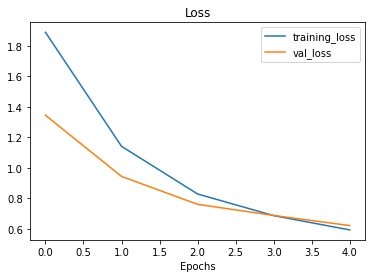

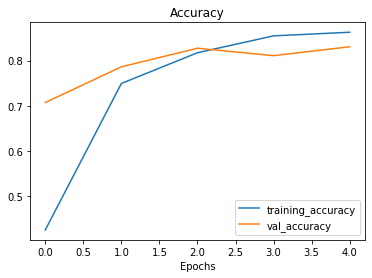

In [40]:
# Check out our model's training curves
plot_loss_curves(history_10_percent)

## Getting a feature vector from a trained model

Let's demonstrate the Global Average Pooling 2D layer...

We have a tensor after our model goes through `base_model` of shape (None, 7, 7, 1280).

But then when it passes through GlobalAveragePooling2D, it turns into (None, 1280).

Let's use a similar shaped tensor of (1, 4, 4, 3) and the pass it to GlobalAveragePooling2D.

In [41]:
# Define the input shape
input_shape = (1, 4, 4, 3)

# Create a random tensor
tf.random.set_seed(42)
input_tensor = tf.random.normal(input_shape)
print(f'Random input tensor:\n {input_tensor}\n')

# Pass the random tensor through a global average polling 2D layer
global_average_pooled_tensor = tf.keras.layers.GlobalAveragePooling2D()(input_tensor)
print(f'2D global average pooled random tensor:\n {global_average_pooled_tensor}\n')

# Check the shape of the different tensors
print(f'Shape of input tensor: {input_tensor.shape}')
print(f'Shape of Global Average Pooled 2D tensor: {global_average_pooled_tensor.shape}')

Random input tensor:
 [[[[ 0.3274685  -0.8426258   0.3194337 ]
   [-1.4075519  -2.3880599  -1.0392479 ]
   [-0.5573232   0.539707    1.6994323 ]
   [ 0.28893656 -1.5066116  -0.2645474 ]]

  [[-0.59722406 -1.9171132  -0.62044144]
   [ 0.8504023  -0.40604794 -3.0258412 ]
   [ 0.9058464   0.29855987 -0.22561555]
   [-0.7616443  -1.8917141  -0.93847126]]

  [[ 0.77852213 -0.47338897  0.97772694]
   [ 0.24694404  0.20573747 -0.5256233 ]
   [ 0.32410017  0.02545409 -0.10638497]
   [-0.6369475   1.1603122   0.2507359 ]]

  [[-0.41728503  0.4012578  -1.4145443 ]
   [-0.5931857  -1.6617213   0.33567193]
   [ 0.10815629  0.23479682 -0.56668764]
   [-0.35819843  0.88698614  0.52744764]]]]

2D global average pooled random tensor:
 [[-0.09368646 -0.45840448 -0.2885598 ]]

Shape of input tensor: (1, 4, 4, 3)
Shape of Global Average Pooled 2D tensor: (1, 3)


In [42]:
# Let's replicate the GlobalAveragePooling2D layer
tf.reduce_mean(input_tensor, axis=[1, 2])

<tf.Tensor: shape=(1, 3), dtype=float32, numpy=array([[-0.09368646, -0.45840448, -0.2885598 ]], dtype=float32)>

> 🔧 **Practice:** Try to do the same with the above two cells but this time use `GlobalMaxPooling2D`... and see what happens.

In [43]:
global_max_pooled_tensor = tf.keras.layers.GlobalMaxPool2D()(input_tensor)
print(f'2D global max pooled random tensor:\n {global_max_pooled_tensor}\n')

2D global max pooled random tensor:
 [[0.9058464 1.1603122 1.6994323]]



### Running a series of transfer learning experiments

We've seen the incredible results transfer learning can get with only 10% of the training data, but how goes it go with 1% of the training data... how about we set up a bunch of experiments to find out:

1. `model_1` - use feature extraction transfer learning with 1% of the training data with data augmentation
2. `model_2` - use feature extraction transfer learning with 10% of the trainng with data augmentation
3. `model_3` - use fine-tuning transfer learning on 10% of the training data with data augmentation
4. `model_4` - use fine-tuning transfer learning on 100% of the training data with data augmentation

> 🔑 **Note:** throughout all experiments the same test dataset will be used to evaluate our model... this ensures consistency across evaluation metrics.

## Getting and preprocessing data for model_1

In [44]:
# Download and unzip data - preprocessed from Food101
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip
unzip_data('10_food_classes_1_percent.zip')

--2022-06-10 09:54:42--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.135.128, 74.125.142.128, 74.125.195.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.135.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 133612354 (127M) [application/zip]
Saving to: ‘10_food_classes_1_percent.zip’

10_food_classes_1_p 100%[===================>] 127.42M   195MB/s    in 0.7s    

2022-06-10 09:54:43 (195 MB/s) - ‘10_food_classes_1_percent.zip’ saved [133612354/133612354]



In [45]:
# Create training and test dirs
train_dir_1_percent = '10_food_classes_1_percent/train'
test_dir = '10_food_classes_1_percent/test'

In [46]:
# How many images are we working with?
walk_through_dir('10_food_classes_1_percent')

There are 2 directories and 0 images in '10_food_classes_1_percent'.
There are 10 directories and 0 images in '10_food_classes_1_percent/train'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/sushi'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/pizza'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/chicken_curry'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/fried_rice'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/ice_cream'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/steak'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/chicken_wings'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/ramen'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/hamburger'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/grilled_salmon'.
There a

In [47]:
# Setup data loaders
IMG_SIZE = (224, 224)
train_data_1_percent = tf.keras.utils.image_dataset_from_directory(train_dir_1_percent,
                                                                   label_mode='categorical',
                                                                   image_size=IMG_SIZE,
                                                                   batch_size=BATCH_SIZE)
test_data = tf.keras.utils.image_dataset_from_directory(test_dir,
                                                        label_mode='categorical',
                                                        image_size=IMG_SIZE,
                                                        batch_size=BATCH_SIZE)

Found 70 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


## Adding data augmentation right into the model

To add data augmentation right into our models, we can use the layers inside:

* `tf.keras.layers.experimental.preprocessing()`

*this is actually outdated in TF2.9 and most data augmentation has been moved to `tf.keras.layers`

In [48]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# Create data augmentation stage with horizontal flipping, rotations, zooms, etc
data_augmentation = keras.Sequential([
    layers.RandomFlip('horizontal'),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
    layers.RandomHeight(0.2),
    layers.RandomWidth(0.2),
    # layers.Rescale(1./255) # Keep for models like ResNet50V2 but EfficientNet's have rescaling built-in
], name="data_augmentation")